# Import Libraries

In [37]:

import os
from torchvision.transforms import Compose, Resize, InterpolationMode, ToTensor, Normalize, RandomCrop, RandomHorizontalFlip
import torch
from code.classifier import PneumoniaClassifier, Config
from code.plot_random_image import plot_random_image_from_loader
from code.classify_random_images import plot_random_images_with_labels
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
from torchvision import transforms
from code.classifier import PneumoniaClassifier
from code.dataloader import DataLoader



In [38]:

# Load the TensorBoard
%reload_ext tensorboard
%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [39]:
# Enable CUDA Launch Blocking
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# Set float32 matrix multiplication precision to 'medium' to utilize Tensor Cores
torch.set_float32_matmul_precision('medium')
torch.serialization.add_safe_globals([Compose, Resize, set, Config, InterpolationMode, ToTensor, Normalize, RandomHorizontalFlip])

# Check GPU Availability

In [40]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Thu Dec  5 21:45:23 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.90                 Driver Version: 565.90         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 Ti   WDDM  |   00000000:02:00.0  On |                  N/A |
|  0%   42C    P8             12W /  285W |    3356MiB /  12282MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Setup Model

In [41]:
config = Config(
    backbone_name="google/vit-base-patch16-224",
    transfer_learning=True,
    learning_rate=1e-5,
    batch_size=32,
    max_epochs=100,
    weight_decay=1e-5,
    dropout=0.3,
    num_workers=16,
    model_name="Vit-unfreeze",
    version="001",
    optimizer_name = "adam",
    use_class_weights=True,
    image_res=384,
    patience = 10,
    image_type=3
)
model = PneumoniaClassifier(config)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)




Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000026A09813560>
Traceback (most recent call last):
  File "C:\Users\aszab\miniconda3\envs\pneumonia_detection\Lib\site-packages\torch\utils\data\dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "C:\Users\aszab\miniconda3\envs\pneumonia_detection\Lib\site-packages\torch\utils\data\dataloader.py", line 1568, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "C:\Users\aszab\miniconda3\envs\pneumonia_detection\Lib\multiprocessing\process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\aszab\miniconda3\envs\pneumonia_detection\Lib\multiprocessing\popen_spawn_win32.py", line 112, in wait
    res = _winapi.WaitForSingleObject(int(self._handle), msecs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt: 

KeyboardInterrupt



# Plot random images from all datasets

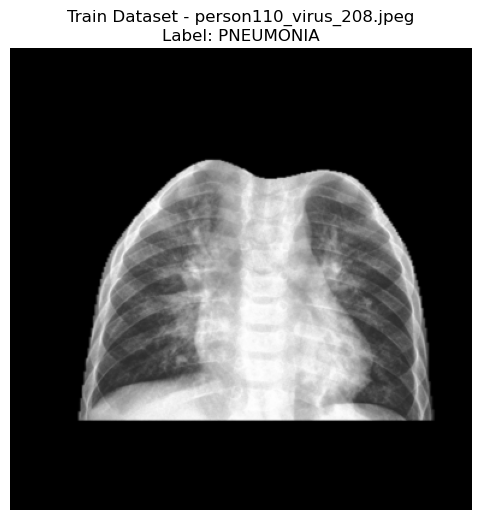

In [24]:
plot_random_image_from_loader(model.train_loader.dataset, "Train Dataset", normalize=False)

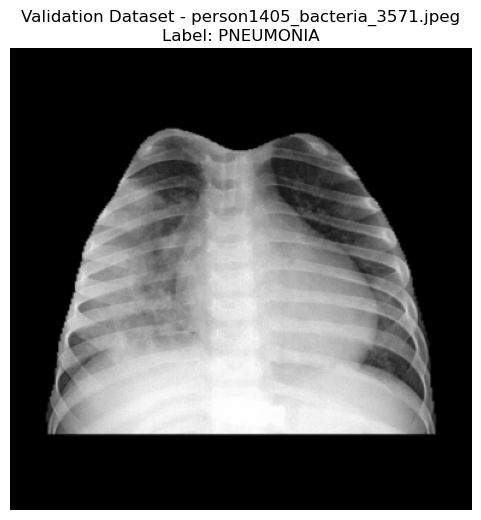

In [25]:
plot_random_image_from_loader(model.val_loader.dataset, "Validation Dataset", normalize=False)

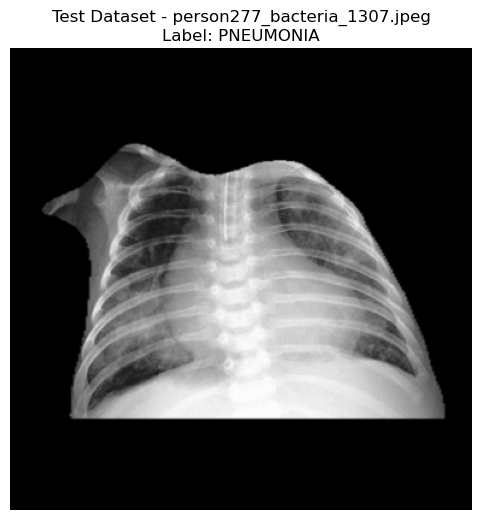

In [26]:
plot_random_image_from_loader(model.test_loader.dataset, "Test Dataset", normalize=False)

# Train Model

In [27]:

# Train Model
model.train_model()
torch.save({
    "state_dict": model.state_dict(),
    "config": config
}, f"../models/{config.model_name}_final.pt")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type                      | Params | Mode 
------------------------------------------------------------------------
0 | accuracy          | BinaryAccuracy            | 0      | train
1 | precision         | BinaryPrecision           | 0      | train
2 | recall            | BinaryRecall              | 0      | train
3 | f1                | BinaryF1Score             | 0      | train
4 | specificity       | BinarySpecificity         | 0      | train
5 | feature_extractor | ViTForImageClassification | 85.8 M | eval 
------------------------------------------------------------------------
85.8 M    Trainable params
0         Non-trainable params
85.8 M    Total params
343.201   Total estimated model params size (MB)
6         Modules in train mode
225       Modules in eval mode


Epoch 0: 100%|██████████| 129/129 [02:08<00:00,  1.00it/s, v_num=3, train_loss_step=0.603]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 129/129 [02:34<00:00,  0.84it/s, v_num=3, train_loss_step=0.603, val_acc_epoch=0.704, val_precision_epoch=0.877, val_recall_epoch=0.691, val_f1_epoch=0.773, val_specificity_epoch=0.738]

C:\Users\aszab\miniconda3\envs\pneumonia_detection\Lib\site-packages\pytorch_lightning\utilities\data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 14. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
Metric val_loss improved. New best score: 0.456


Epoch 1: 100%|██████████| 129/129 [02:02<00:00,  1.05it/s, v_num=3, train_loss_step=0.545, val_acc_epoch=0.704, val_precision_epoch=0.877, val_recall_epoch=0.691, val_f1_epoch=0.773, val_specificity_epoch=0.738]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 129/129 [02:01<00:00,  1.06it/s, v_num=3, train_loss_step=0.134, val_acc_epoch=0.768, val_precision_epoch=0.904, val_recall_epoch=0.764, val_f1_epoch=0.828, val_specificity_epoch=0.780]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 129/129 [02:27<00:00,  0.87it/s, v_num=3, train_loss_step=0.134, val_acc_epoch=0.816, val_precision_epoch=0.918, val_recall_epoch=0.821, val_f1_epoch=0.867, val_specificity_epoch=0.801]

Metric val_loss improved by 0.136 >= min_delta = 0.0. New best score: 0.320


Epoch 3: 100%|██████████| 129/129 [02:04<00:00,  1.03it/s, v_num=3, train_loss_step=0.159, val_acc_epoch=0.816, val_precision_epoch=0.918, val_recall_epoch=0.821, val_f1_epoch=0.867, val_specificity_epoch=0.801]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 129/129 [02:31<00:00,  0.85it/s, v_num=3, train_loss_step=0.159, val_acc_epoch=0.850, val_precision_epoch=0.936, val_recall_epoch=0.852, val_f1_epoch=0.892, val_specificity_epoch=0.843]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.306


Epoch 4: 100%|██████████| 129/129 [02:04<00:00,  1.04it/s, v_num=3, train_loss_step=0.346, val_acc_epoch=0.850, val_precision_epoch=0.936, val_recall_epoch=0.852, val_f1_epoch=0.892, val_specificity_epoch=0.843]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 129/129 [02:03<00:00,  1.04it/s, v_num=3, train_loss_step=0.210, val_acc_epoch=0.839, val_precision_epoch=0.948, val_recall_epoch=0.825, val_f1_epoch=0.882, val_specificity_epoch=0.878]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 129/129 [02:29<00:00,  0.86it/s, v_num=3, train_loss_step=0.210, val_acc_epoch=0.876, val_precision_epoch=0.943, val_recall_epoch=0.885, val_f1_epoch=0.913, val_specificity_epoch=0.854]

Metric val_loss improved by 0.101 >= min_delta = 0.0. New best score: 0.205


Epoch 6: 100%|██████████| 129/129 [02:01<00:00,  1.06it/s, v_num=3, train_loss_step=0.0313, val_acc_epoch=0.876, val_precision_epoch=0.943, val_recall_epoch=0.885, val_f1_epoch=0.913, val_specificity_epoch=0.854]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 129/129 [01:59<00:00,  1.08it/s, v_num=3, train_loss_step=0.0283, val_acc_epoch=0.884, val_precision_epoch=0.957, val_recall_epoch=0.881, val_f1_epoch=0.918, val_specificity_epoch=0.894]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 129/129 [02:24<00:00,  0.89it/s, v_num=3, train_loss_step=0.0283, val_acc_epoch=0.901, val_precision_epoch=0.956, val_recall_epoch=0.905, val_f1_epoch=0.930, val_specificity_epoch=0.888]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.204


Epoch 8: 100%|██████████| 129/129 [02:03<00:00,  1.05it/s, v_num=3, train_loss_step=0.323, val_acc_epoch=0.901, val_precision_epoch=0.956, val_recall_epoch=0.905, val_f1_epoch=0.930, val_specificity_epoch=0.888]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 129/129 [02:03<00:00,  1.04it/s, v_num=3, train_loss_step=1.240, val_acc_epoch=0.903, val_precision_epoch=0.962, val_recall_epoch=0.903, val_f1_epoch=0.931, val_specificity_epoch=0.903]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 129/129 [02:30<00:00,  0.86it/s, v_num=3, train_loss_step=1.240, val_acc_epoch=0.905, val_precision_epoch=0.958, val_recall_epoch=0.909, val_f1_epoch=0.933, val_specificity_epoch=0.893]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.196


Epoch 10: 100%|██████████| 129/129 [02:01<00:00,  1.06it/s, v_num=3, train_loss_step=0.951, val_acc_epoch=0.905, val_precision_epoch=0.958, val_recall_epoch=0.909, val_f1_epoch=0.933, val_specificity_epoch=0.893]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 129/129 [02:27<00:00,  0.87it/s, v_num=3, train_loss_step=0.951, val_acc_epoch=0.914, val_precision_epoch=0.965, val_recall_epoch=0.916, val_f1_epoch=0.940, val_specificity_epoch=0.909]

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.176


Epoch 11: 100%|██████████| 129/129 [02:01<00:00,  1.06it/s, v_num=3, train_loss_step=0.366, val_acc_epoch=0.914, val_precision_epoch=0.965, val_recall_epoch=0.916, val_f1_epoch=0.940, val_specificity_epoch=0.909]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 129/129 [02:00<00:00,  1.07it/s, v_num=3, train_loss_step=0.054, val_acc_epoch=0.895, val_precision_epoch=0.961, val_recall_epoch=0.892, val_f1_epoch=0.925, val_specificity_epoch=0.901]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 129/129 [02:01<00:00,  1.06it/s, v_num=3, train_loss_step=0.350, val_acc_epoch=0.903, val_precision_epoch=0.964, val_recall_epoch=0.901, val_f1_epoch=0.931, val_specificity_epoch=0.909]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 129/129 [02:01<00:00,  1.07it/s, v_num=3, train_loss_step=0.0856, val_acc_epoch=0.906, val_precision_epoch=0.967, val_recall_epoch=0.902, val_f1_epoch=0.933, val_specificity_epoch=0.916]
Validatio

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.176. Signaling Trainer to stop.


Epoch 20: 100%|██████████| 129/129 [02:27<00:00,  0.88it/s, v_num=3, train_loss_step=0.0355, val_acc_epoch=0.940, val_precision_epoch=0.979, val_recall_epoch=0.939, val_f1_epoch=0.958, val_specificity_epoch=0.945]


# Load Model

In [28]:

checkpoint = torch.load(f"../models/{config.model_name}_final.pt")
loaded_config = checkpoint["config"]
model = PneumoniaClassifier(loaded_config)
model.load_state_dict(checkpoint["state_dict"])
model.eval()
model = model.to(device)

C:\Users\aszab\AppData\Local\Temp\ipykernel_26184\2110236150.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f"../models/{config.model_name}_fina

# Test Model

In [30]:
# Run testing
print("Testing the model...")
checkpoint_path = f"../checkpoints/{config.model_name}.ckpt"
test_metadata = model.test_model(checkpoint_path)  # Ensure this uses the correct test_loader

Testing the model...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 28/28 [00:24<00:00,  1.12it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_acc_epoch         0.9453924894332886
      test_f1_epoch         0.9617834687232971
  test_precision_epoch      0.9821138381958008
    test_recall_epoch       0.9422776699066162
 test_specificity_epoch     0.9537814855575562
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


# Plot Confusion Matrix

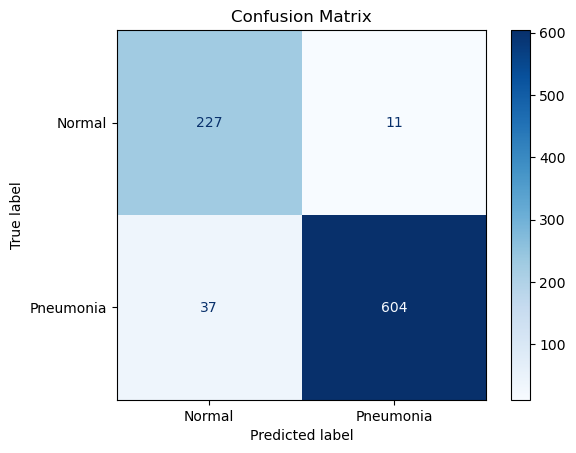

In [31]:
def plot_confusion_matrix(model, dataloader, class_names):
    all_preds = []
    all_labels = []

    # Get predictions and true labels
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        for data, labels, _ in dataloader:
            data = data.cuda()  # Move data to GPU if available
            labels = labels.cuda()
            preds = torch.argmax(model(data), dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

# Call this after training/testing
plot_confusion_matrix(model, model.test_loader, class_names=["Normal", "Pneumonia"])

# Plot ROC/AUC Score

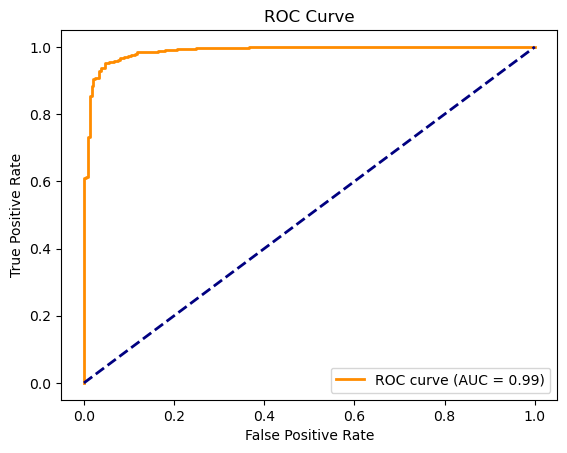

In [32]:
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_auc(model, dataloader):
    all_preds = []
    all_labels = []

    # Get predictions and true labels
    model.eval()
    with torch.no_grad():
        for data, labels, _ in dataloader:
            data = data.cuda()
            labels = labels.cuda()
            preds = model(data)
            probs = torch.softmax(preds, dim=1)[:, 1]  # Probabilities for class 1
            all_preds.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_preds)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_auc(model, model.test_loader)

# Plot Gradcam

In [35]:
for param in model.feature_extractor.parameters():
    param.requires_grad = True

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np

def reshape_transform(tensor):
    activations = tensor[:, 1:, :]
    activations = activations.reshape(activations.shape[0], int(np.sqrt(activations.shape[1])), -1, activations.shape[2])
    return activations.permute(0, 3, 1, 2)

# Use the last layer of the encoder as the target
target_layer = model.feature_extractor.vit.encoder.layer[-1]

# Initialize Grad-CAM
cam = GradCAM(model=model, target_layers=[target_layer], reshape_transform=reshape_transform)

# Pass input image tensor
input_tensor = inputs  # Your input tensor
grayscale_cam = cam(input_tensor=input_tensor)

# Visualize Grad-CAM
heatmap = show_cam_on_image(rgb_image, grayscale_cam[0], use_rgb=True)



Exception ignored in: <function BaseCAM.__del__ at 0x0000026A26838180>
Traceback (most recent call last):
  File "C:\Users\aszab\miniconda3\envs\pneumonia_detection\Lib\site-packages\pytorch_grad_cam\base_cam.py", line 189, in __del__
    self.activations_and_grads.release()
    ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'GradCAM' object has no attribute 'activations_and_grads'


TypeError: GradCAM.__init__() got an unexpected keyword argument 'use_cuda'

# Evaluate Metrics in Tensorboard

In [15]:
# Load TensorBoard extension
%load_ext tensorboard

# Specify the log directory
log_dir = f"tb_logs/{config.model_name}"

# Start TensorBoard
%tensorboard --logdir {log_dir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Classify random images

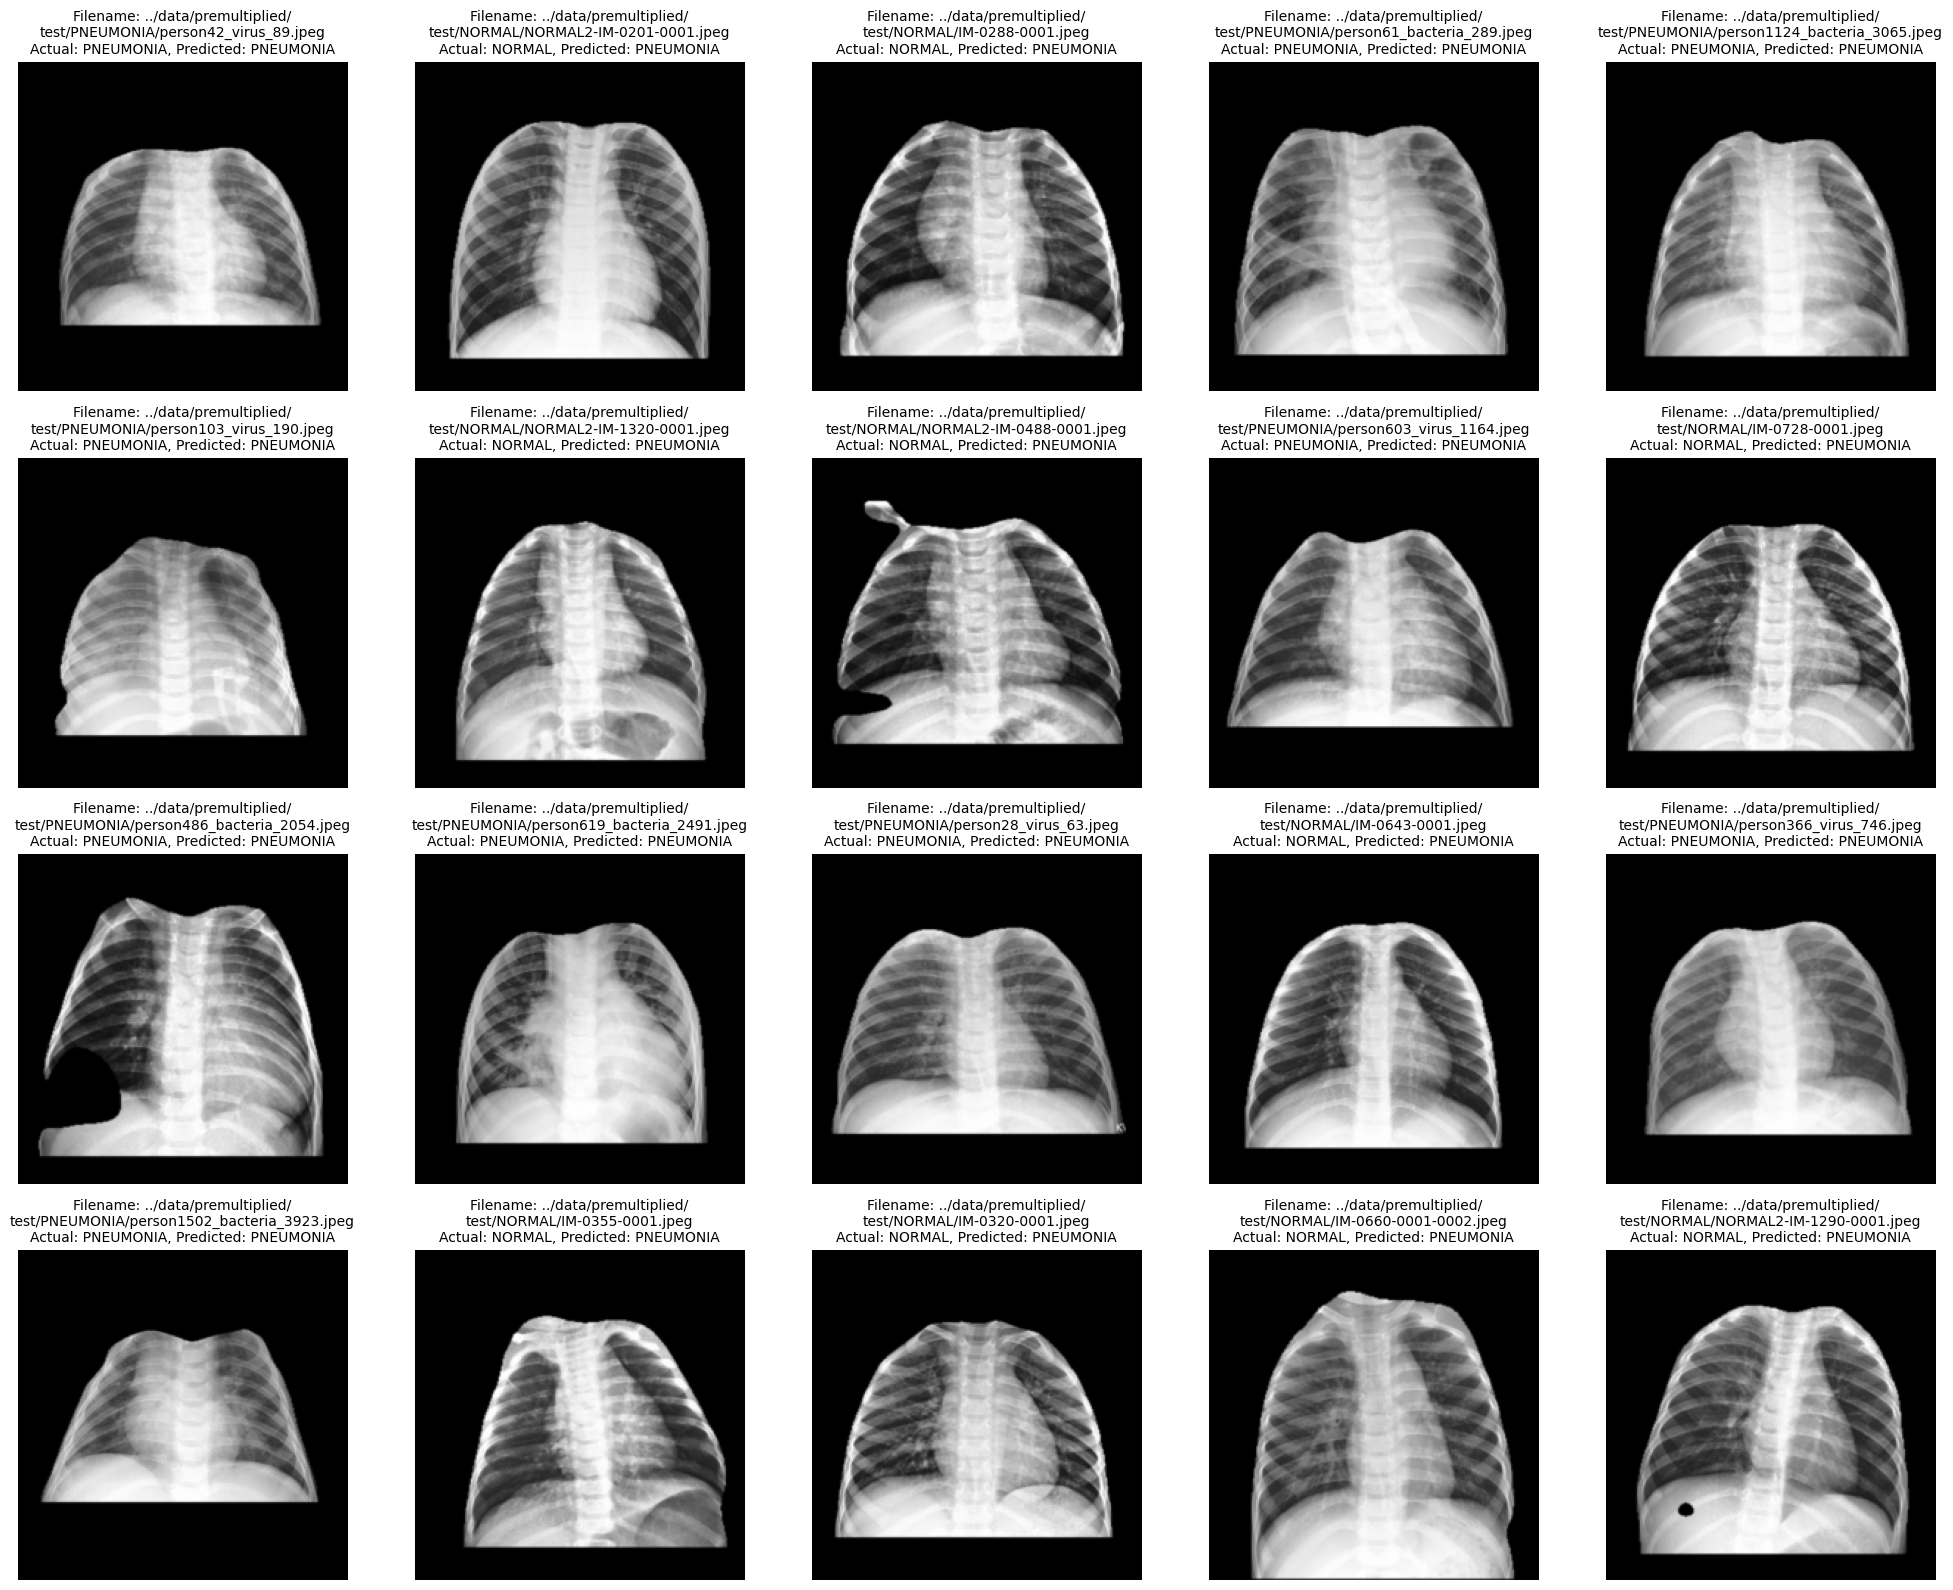

In [16]:
plot_random_images_with_labels(model, model.test_loader, num_images=20)